# Projet de Transfer Learning

### Introduction :
Dans le cadre de l'UE Deep Learning, nous avons utilisé le principe de Transfer Learning afin d'implémenter un modèle de classification d'images pour différents personnages du manga One Piece. On dispose pour ce projet d'une base d'image trouvée sur kaggle : https://www.kaggle.com/datasets/ibrahimserouis99/one-piece-image-classifier

Ce dataset comprend 18 classes (18 personnages différents de One Piece) pour un total de 11 736 images (~650 / classe). Ces images sont déjà augmentées, c'est a dire que chaque classe dispose déjà d'un jeu d'image ainsi que de ce même jeu modifié (inversion de couleurs, rotations...).

Dans un premier temps nous essaierons de créer un CNN et d'évaluer ses performances. Par la suite nous implémenterons un CNN intégré aux modèles vgg-16 pré-entrainé et ResNet50 pré-entrainé. 



# 1. CNN Pour la classification d'images.
Dans cette première partie nous avons implémenté un CNN adapté à notre problème. 

Commençons par importer les librairies nécessaires et télécharger le dataset :

In [1]:
import tensorflow as tf

# Forcer l'utilisation de la mémoire GPU dynamique
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.executing_eagerly()

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
import kagglehub
import os
import matplotlib.pyplot as plt



# télécharger les données
path = kagglehub.dataset_download("ibrahimserouis99/one-piece-image-classifier")
data_dir = os.path.join(path, "Data", "Data")
print("Path to dataset files:", data_dir)


c:\Users\matth\miniconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\matth\.cache\kagglehub\datasets\ibrahimserouis99\one-piece-image-classifier\versions\23\Data\Data


Ensuite, on va appliquer les modifications nécessaires aux images afin qu'elles puissent servir d'entrainement pour notre modèle. Cela comprend le chargement et l'indexation des classes ainsi que le traitement de l'image (modifier la taille, normaliser les pixels).

In [2]:
# Définir les tailles des images
image_size = (150, 150)
batch_size = 32

# Créer les générateurs d'images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,  # Réserver 20% des données d'entraînement pour la validation

)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Charger les données à partir des répertoires
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Extraire les classes
num_classes = len(train_generator.class_indices)
print(f"Classes détectées : {train_generator.class_indices}")

Found 9396 images belonging to 18 classes.
Found 2341 images belonging to 18 classes.
Found 11737 images belonging to 18 classes.
Classes détectées : {'Ace': 0, 'Akainu': 1, 'Brook': 2, 'Chopper': 3, 'Crocodile': 4, 'Franky': 5, 'Jinbei': 6, 'Kurohige': 7, 'Law': 8, 'Luffy': 9, 'Mihawk': 10, 'Nami': 11, 'Rayleigh': 12, 'Robin': 13, 'Sanji': 14, 'Shanks': 15, 'Usopp': 16, 'Zoro': 17}


On définit le modèle. 

On a choisit une activation linéaire et pour la dernière couche dense, un softmax. Softmax est plus adapté dans la classification multiclasse que sigmoid.

En effet Softmax produit une probabilité unique pour chaque personnage, et l'algorithme prédit la classe avec la probabilité maximale. Tandis que sigmoid peut prédire que plusieurs personnages sont présents simultanément (ce qui n'est pas réaliste pour cette tâche). Softmax est donc plus adapté à la classification multi-classes car il normalise les scores en probabilités cohérentes et suppose des classes mutuellement exclusives, ce qui correspond aux hypothèses de la tâche. Sigmoid, en revanche, est conçu pour des classes indépendantes, ce qui n'est pas le cas ici

In [3]:
modelCNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Afficher le résumé du modèle
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [4]:
modelCNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

On passe à l'entrainement du modèle : 

In [5]:
# Entraîner le modèle avec les générateurs
epochs = 30

historyCNN = modelCNN.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/30
 63/294 [=====>........................] - ETA: 48s - loss: 2.8745 - accuracy: 0.0609

c:\Users\matth\miniconda3\envs\py310\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


294/294 [==============================] - 95s 296ms/step - loss: 2.6005 - accuracy: 0.1749 - val_loss: 2.5860 - val_accuracy: 0.2063
Epoch 2/30
294/294 [==============================] - 77s 262ms/step - loss: 1.9793 - accuracy: 0.3839 - val_loss: 2.1935 - val_accuracy: 0.3460
Epoch 3/30
294/294 [==============================] - 73s 248ms/step - loss: 1.4639 - accuracy: 0.5447 - val_loss: 2.0247 - val_accuracy: 0.4216
Epoch 4/30
294/294 [==============================] - 63s 216ms/step - loss: 0.9919 - accuracy: 0.6891 - val_loss: 2.0611 - val_accuracy: 0.4455
Epoch 5/30
294/294 [==============================] - 64s 219ms/step - loss: 0.5534 - accuracy: 0.8238 - val_loss: 2.2212 - val_accuracy: 0.4720
Epoch 6/30
294/294 [==============================] - 63s 215ms/step - loss: 0.3021 - accuracy: 0.9061 - val_loss: 2.8067 - val_accuracy: 0.4554
Epoch 7/30
294/294 [==============================] - 63s 215ms/step - loss: 0.1724 - accuracy: 0.9464 - val_loss: 2.9648 - val_accuracy: 0.4

On sauvegarde le modèle et on visualise les performances :

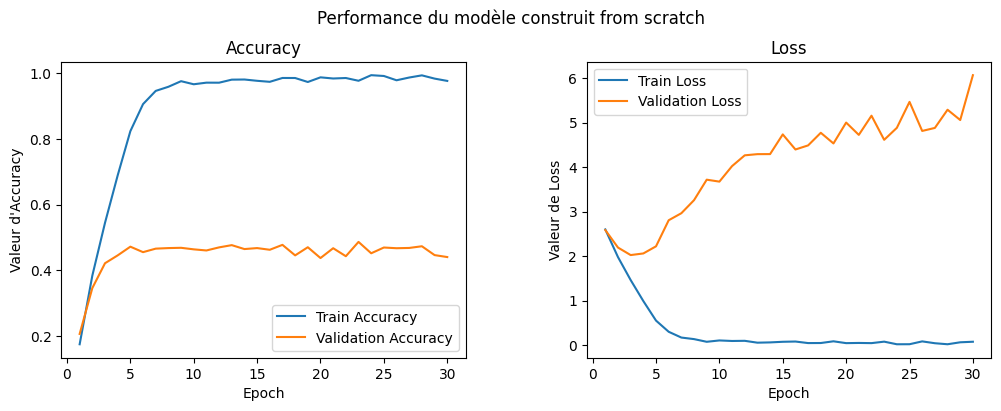

In [6]:
modelCNN.save("./weights/model_from_scratch.h5")

# Visualisation des performances
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
f.suptitle('Performance du modèle construit from scratch', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, len(historyCNN.history['accuracy']) + 1))

ax1.plot(epoch_list, historyCNN.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, historyCNN.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Valeur d\'Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.legend(loc="best")

ax2.plot(epoch_list, historyCNN.history['loss'], label='Train Loss')
ax2.plot(epoch_list, historyCNN.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Valeur de Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend(loc="best")

plt.show()

La Validation Accuracy tourne autour des <span style="color:red;"> 50 % </span>, avec un surapprentissage

# Utilisation de VGG-16 pré-entrainé avec le CNN. 

Dans cette partie, on va s'appuyer de VGG-16 pré-entrainé, et ajouter un modèle complètement connecté à la fin qui permettra de faire notre classification d'images.

On définit notre nouveau modèle : 

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dropout

# Charger le modèle VGG16
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Geler les couches pré-entraînées

# Ajouter des couches personnalisées
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')  
dense_layer_2 = layers.Dense(256, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')  # Nombre de classes en sortie

# Créer le modèle
modelTL = models.Sequential([
    base_model, # Ajouter le modèle VGG16
    flatten_layer,
    dense_layer_1,
    Dropout(0.3), # Ajout de dropout pour éviter le surapprentissage
    dense_layer_2,
    Dropout(0.3), # Ajout de dropout pour éviter le surapprentissage
    prediction_layer
])

# Afficher le résumé du modèle
modelTL.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 18)               

On passe à l'entrainement :

In [8]:
tf.keras.backend.clear_session() # Nettoyer les anciens modèles 

epochs = 30

modelTL.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

historyTL = modelTL.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/30
  3/294 [..............................] - ETA: 21s - loss: 3.5621 - accuracy: 0.0625 

c:\Users\matth\miniconda3\envs\py310\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


294/294 [==============================] - 68s 218ms/step - loss: 2.2779 - accuracy: 0.2968 - val_loss: 1.8689 - val_accuracy: 0.4357
Epoch 2/30
294/294 [==============================] - 65s 221ms/step - loss: 1.5314 - accuracy: 0.5281 - val_loss: 1.5296 - val_accuracy: 0.5340
Epoch 3/30
294/294 [==============================] - 61s 207ms/step - loss: 1.0974 - accuracy: 0.6607 - val_loss: 1.3986 - val_accuracy: 0.5656
Epoch 4/30
294/294 [==============================] - 61s 206ms/step - loss: 0.8337 - accuracy: 0.7381 - val_loss: 1.2748 - val_accuracy: 0.6211
Epoch 5/30
294/294 [==============================] - 61s 207ms/step - loss: 0.6643 - accuracy: 0.7891 - val_loss: 1.3865 - val_accuracy: 0.6010
Epoch 6/30
294/294 [==============================] - 61s 207ms/step - loss: 0.5410 - accuracy: 0.8290 - val_loss: 1.3909 - val_accuracy: 0.6164
Epoch 7/30
294/294 [==============================] - 61s 209ms/step - loss: 0.4710 - accuracy: 0.8467 - val_loss: 1.4887 - val_accuracy: 0.6

Affichage des performances : 

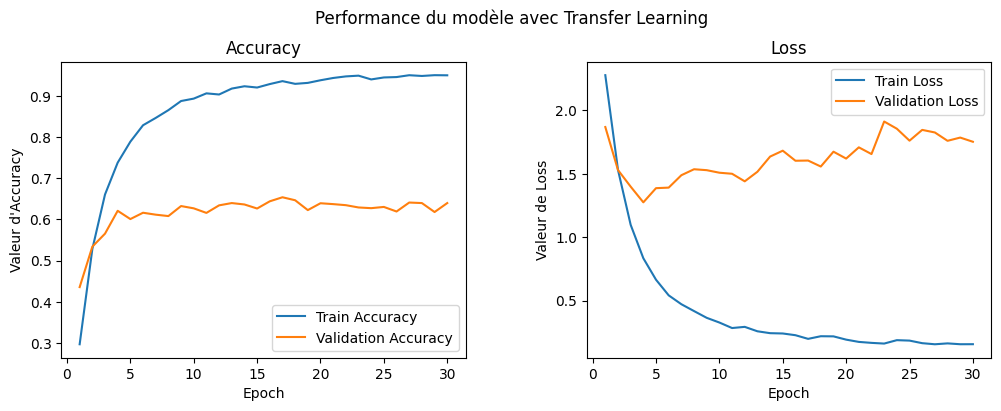

In [9]:
modelTL.save("./weights/modelTL1.h5")

# Visualisation des performances
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
f.suptitle('Performance du modèle avec Transfer Learning', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, epochs + 1))

ax1.plot(epoch_list, historyTL.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, historyTL.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Valeur d\'Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.legend(loc="best")

ax2.plot(epoch_list, historyTL.history['loss'], label='Train Loss')
ax2.plot(epoch_list, historyTL.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Valeur de Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend(loc="best")

plt.show()

On a toujours du surapprentissage, cependant la validation accuracy tourne maintenant autour des <span style="color:red;"> 60%</span>. 

# 3 Transfer Learning avec Fine Tuning

Enfin, nous allons réaliser du Fine Tuning sur le modèle précedant. Le principe du Fine Tuning consiste à "dégeler" certaines couches du modèle pré-entrainé afin de les re-entrainer pour notre cas d'utilisation. Dans notre cas, nous allons dégeler les 9 couches qui précèdent nos couches personnalisés, ce qui représente un re entrainement des couches à partir de la couche *block4_conv1*.

In [10]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
base_model.trainable = True  # Rendre toutes les couches entraînables
fine_tune_at = len(base_model.layers) - 9  # Ne dégeler que les 9 dernières couches

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False  # Garder les couches inférieures gelées

# Ajouter des couches personnalisées
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dense_layer_2 = layers.Dense(256, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

# Créer le modèle
modelTL_FT = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    Dropout(0.3), # Ajout de dropout pour éviter le surapprentissage
    dense_layer_2,
    Dropout(0.3), # Ajout de dropout pour éviter le surapprentissage
    prediction_layer
])

On passe à l'entrainement du modèle.

In [11]:
tf.keras.backend.clear_session() # Nettoyer les anciens modèles 

epochs = 100

#Compiler le modèle
modelTL_FT.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Learning rate plus bas pour fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

historyTL_FT = modelTL_FT.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)


Epoch 1/100
294/294 [==============================] - 80s 258ms/step - loss: 2.8357 - accuracy: 0.0833 - val_loss: 2.5760 - val_accuracy: 0.1687
Epoch 2/100
294/294 [==============================] - 73s 248ms/step - loss: 2.3448 - accuracy: 0.2539 - val_loss: 1.9909 - val_accuracy: 0.3943
Epoch 3/100
294/294 [==============================] - 73s 247ms/step - loss: 1.6944 - accuracy: 0.4712 - val_loss: 1.5363 - val_accuracy: 0.5352
Epoch 4/100
294/294 [==============================] - 73s 249ms/step - loss: 1.0873 - accuracy: 0.6681 - val_loss: 1.2628 - val_accuracy: 0.6271
Epoch 5/100
294/294 [==============================] - 73s 249ms/step - loss: 0.7159 - accuracy: 0.7826 - val_loss: 1.5074 - val_accuracy: 0.5976
Epoch 6/100
294/294 [==============================] - 69s 236ms/step - loss: 0.4586 - accuracy: 0.8615 - val_loss: 0.9407 - val_accuracy: 0.7569
Epoch 7/100
294/294 [==============================] - 69s 233ms/step - loss: 0.2809 - accuracy: 0.9150 - val_loss: 1.0209 -

On affiche les résultats : 

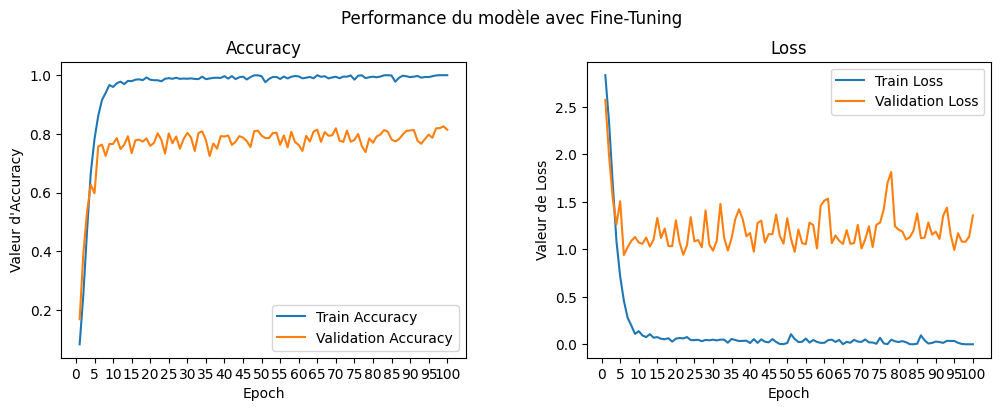

In [12]:

modelTL_FT.save("./weights/modelTL_finetuned.h5")

# Visualisation des performances
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
f.suptitle('Performance du modèle avec Fine-Tuning', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, len(historyTL_FT.history['accuracy']) + 1))

ax1.plot(epoch_list, historyTL_FT.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, historyTL_FT.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Valeur d\'Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.legend(loc="best")

ax2.plot(epoch_list, historyTL_FT.history['loss'], label='Train Loss')
ax2.plot(epoch_list, historyTL_FT.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Valeur de Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend(loc="best")

plt.show()

Encore une fois, le surapprentissage est toujours présent, mais au bout de plus d'epochs. Egalement, la validation accuracy a une nouvelle fois augmenter pour avoisiner les <span style="color:red;"> 80%</span>.

# 4 Essai avec un autre modèle pré-entrainé (ResNet50) :
On reprend le même principe que précedemment, mais avec ResNet50 cette fois-ci. Le but ici est de voir si les performances changent d'un modèle à l'autre et si oui, essayer de comprendre pourquoi.


In [13]:
from tensorflow.keras.applications import ResNet50

# Définir les tailles des images
image_size_resnet = (224, 224)
batch_size = 32

# Créer les générateurs d'images
train_datagen_resnet = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,  # Réserver 20% des données d'entraînement pour la validation

)

test_datagen_resnet = ImageDataGenerator(rescale=1.0 / 255)

# Charger les données à partir des répertoires
train_generator_resnet = train_datagen_resnet.flow_from_directory(
    data_dir,
    target_size=image_size_resnet,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator_resnet = train_datagen_resnet.flow_from_directory(
    data_dir,
    target_size=image_size_resnet,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Extraire les classes
num_classes = len(train_generator_resnet.class_indices)
print(f"Classes détectées : {train_generator_resnet.class_indices}")

Found 9396 images belonging to 18 classes.
Found 2341 images belonging to 18 classes.
Classes détectées : {'Ace': 0, 'Akainu': 1, 'Brook': 2, 'Chopper': 3, 'Crocodile': 4, 'Franky': 5, 'Jinbei': 6, 'Kurohige': 7, 'Law': 8, 'Luffy': 9, 'Mihawk': 10, 'Nami': 11, 'Rayleigh': 12, 'Robin': 13, 'Sanji': 14, 'Shanks': 15, 'Usopp': 16, 'Zoro': 17}


On définit notre nouveau modèle : 

In [14]:

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet.trainable = True

for layer in base_model_resnet.layers[:-20]:  # Geler tout sauf les 20 dernières couches
    layer.trainable = False

# Ajouter des couches personnalisées
modelResNet = models.Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Sortie pour le nombre de classes
])

modelResNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

On passe à l'entrainement : 

In [15]:
tf.keras.backend.clear_session() # Nettoyer les anciens modèles 

epochs = 100

# Compiler de nouveau le modèle avec un taux d'apprentissage réduit
modelResNet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continuer l'entraînement avec fine-tuning
historyResNet = modelResNet.fit(
    train_generator_resnet,
    epochs=epochs,
    validation_data=validation_generator_resnet
)

Epoch 1/100
294/294 [==============================] - 72s 230ms/step - loss: 2.8920 - accuracy: 0.0947 - val_loss: 2.8709 - val_accuracy: 0.0991
Epoch 2/100
294/294 [==============================] - 67s 226ms/step - loss: 2.6494 - accuracy: 0.1844 - val_loss: 2.6997 - val_accuracy: 0.1649
Epoch 3/100
294/294 [==============================] - 67s 227ms/step - loss: 2.4627 - accuracy: 0.2480 - val_loss: 2.5762 - val_accuracy: 0.2106
Epoch 4/100
294/294 [==============================] - 66s 225ms/step - loss: 2.3018 - accuracy: 0.3000 - val_loss: 2.4871 - val_accuracy: 0.2328
Epoch 5/100
294/294 [==============================] - 66s 225ms/step - loss: 2.1167 - accuracy: 0.3606 - val_loss: 2.3647 - val_accuracy: 0.2858
Epoch 6/100
294/294 [==============================] - 67s 226ms/step - loss: 1.9403 - accuracy: 0.4239 - val_loss: 2.2948 - val_accuracy: 0.3024
Epoch 7/100
294/294 [==============================] - 75s 255ms/step - loss: 1.7595 - accuracy: 0.4828 - val_loss: 2.2404 -

Sauvgarder et afficher les résultats : 

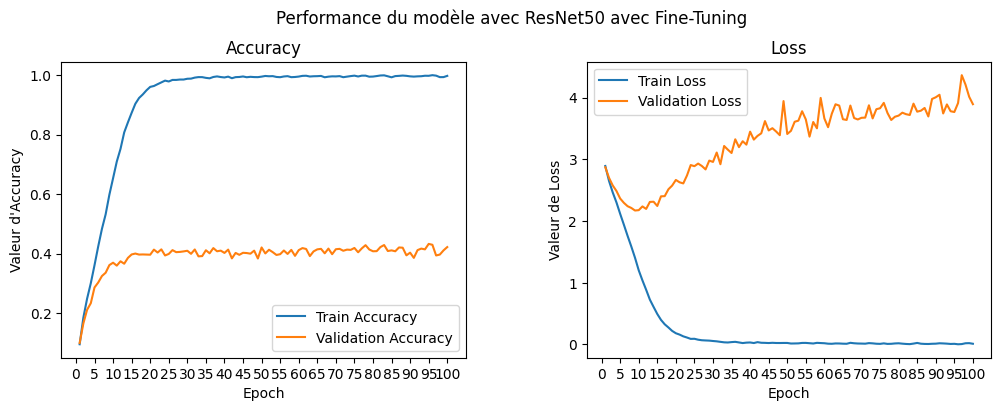

In [16]:

modelResNet.save("./weights/modelTL_finetuned_resnet.h5")

# Visualisation des performances
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
f.suptitle('Performance du modèle avec ResNet50 avec Fine-Tuning', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, len(historyResNet.history['accuracy']) + 1))

ax1.plot(epoch_list, historyResNet.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, historyResNet.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Valeur d\'Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.legend(loc="best")

ax2.plot(epoch_list, historyResNet.history['loss'], label='Train Loss')
ax2.plot(epoch_list, historyResNet.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Valeur de Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend(loc="best")

plt.show()

Les résultats sont ici peu concluants. Une validation accuracy tournant autour des <span style="color:red;"> 40%</span>. Mais pourquoi une telle différence d'un modèle à l'autre ? 

On peut expliquer cela selon plusieurs facteurs : 

* ### Premièrement : la structure et profondeur des modèles.
ResNet50 est plus profond : ResNet50 a 50 couches de profondeur contre 16 pour VGG16. Bien que ResNet soit conçu pour surmonter le problème de dégradation du gradient grâce à ses residual connections, cette profondeur peut rendre le modèle plus difficile à fine-tuner si les données d'entraînement ne sont pas suffisantes ou si les couches gelées ne sont pas bien choisies.
VGG16 est plus simple : La simplicité de VGG16 peut être un avantage pour des tâches où les données sont limitées, car il est moins susceptible de sur-apprendre des caractéristiques complexes et inutiles.

* ### Deuxièmement : la quantité et qualité des données.
ResNet50, étant un modèle plus complexe, il nécessite davantage de données pour apprendre efficacement. Notre ensemble de données est relativement petit (pour 18 classes en sortie) et n'a pas une grande variété, ResNet50 peut donc sous-performer.

* ### Troisièmement : les paramètres d’entraînement.
Des hyperparamètres comme le taux d'apprentissage, la stratégie d'optimisation et le nombre d'épochs peuvent affecter différemment chaque modèle. Un taux d'apprentissage non optimal peut avoir un impact plus marqué sur ResNet50.
ResNet50 est plus sensible aux variations de taille de batch et à des mécanismes comme la normalisation par lots. Le fait que ResNet50 prenne des image 224x224 contre 150x150 pour VGG-16 rend sûrement la tâche plus complexe au premier. 

* ### Dernièrement : l'utilisation du modèle.
ResNet50 est conçu pour capturer des caractéristiques complexes et hiérarchiques, ce qui peut être un inconvénient si les données sont dominées par des motifs simples ou répétitifs, comme dans le style visuel manga testé dans notre cas.

# Conclusion :

Ce projet a permis d'explorer les concepts fondamentaux du *transfer learning* en utilisant deux architectures de réseaux neuronaux profonds pré-entraînés, VGG16 et ResNet50, pour une tâche de classification d'images issues du manga *One Piece*. 

À travers cette étude, nous avons constaté que VGG16, avec sa structure plus simple et directe, a surpassé ResNet50 en termes de précision sur les données de validation, atteignant près de 80% contre 40%. Ces résultats soulignent l'importance de choisir un modèle adapté à la taille, la diversité et la nature des données. La combinaison de la profondeur du modèle, des données limitées ou spécifiques, des choix de fine-tuning, et de la complexité de la tâche explique probablement la supériorité de VGG16 dans ce cas. Adapter davantage ResNet50 (par exemple en augmentant les données, en optimisant les couches dégelées ou en ajustant les hyperparamètres) pourrait améliorer ses performances. 

Ce travail a également mis en évidence les défis liés au fine-tuning des architectures complexes comme ResNet50, notamment la nécessité d'une configuration précise des couches et d'une augmentation de données adaptée. 